In [1]:
import sys
sys.path.insert(0,'..')
from Classifier.VGG import *

Using TensorFlow backend.
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Aleks

In [2]:
from __future__ import print_function
import numpy as np
import os
import keras

In [3]:
weights_path = os.path.join('VGG19_COVID19.h5')

In [4]:
model = VGG19((224,224,3),3)
model.load_weights(weights_path)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
x_test = np.load('data1/x_test.npy')
y_test = np.load('data1/y_test.npy')

In [6]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(len(y_test), 3)
y_pred = np.argmax(y_pred, axis=1)

## Confusion matrix

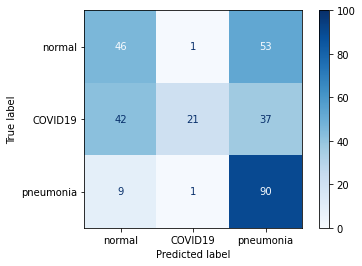

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['normal', 'COVID19', 'pneumonia']))
disp.plot(cmap='Blues') 
disp.ax_.get_images()[0].set_clim(0, 100)

## Precyzja, czułość, F1, dokładność

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.46      0.47       100
           1       0.91      0.21      0.34       100
           2       0.50      0.90      0.64       100

    accuracy                           0.52       300
   macro avg       0.63      0.52      0.48       300
weighted avg       0.63      0.52      0.48       300



## Swoistość

Wyliczenie wszystkich podstawowych metryk z confusion matrix (w tym swoistość, czyli TNR).

In [22]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [20]:
print(TNR)

[0.745 0.99  0.55 ]


## ROC i AUC

In [9]:
def dense_to_one_hot(labels_dense,num_clases=3):
  return np.eye(num_clases)[labels_dense]

In [10]:
y_test1 = dense_to_one_hot(y_test)
y_pred1 = dense_to_one_hot(y_pred)

In [11]:
from sklearn.metrics import roc_curve, auc

n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

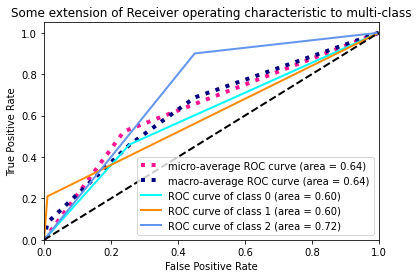

In [12]:
import matplotlib.pyplot as plt
from itertools import cycle

lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.rcParams["figure.figsize"] = (7,6)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Współczynnik Giniego

In [13]:
def gini_coeff(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

In [14]:
n_classes = 3

gini = dict()
for i in range(n_classes):
    gini[i] = gini_coeff(y_test1[:, i], y_pred1[:, i])

In [15]:
gini

{0: 0.24153333333333335, 1: 0.06666666666666667, 2: -0.0033333333333333335}

In [16]:
gini_coeff(y_test, y_pred)

-0.03367777777777775

## Cohen Kappa

In [17]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred))

0.28500000000000003
